In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [3]:
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

ImportError: No module named lda2vec

You must be using a very recent version of pyLDAvis to use the lda2vec outputs. 
As of this writing, anything past Jan 6 2016 or this commit `14e7b5f60d8360eb84969ff08a1b77b365a5878e` should work.
You can do this quickly by installing it directly from master like so:


In [2]:
# pip install -U git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis

In [2]:
import pyLDAvis
pyLDAvis.enable_notebook()

### Reading in the saved model story topics

After runnning `lda2vec_run.py` script in `examples/hacker_news/lda2vec` directory `topics.story.pyldavis.npz` and `topics.author.pyldavis.npz` will be created that contain the topic-to-word probabilities and frequencies. What's left is to visualize and label each topic from the it's prevalent words.

In [3]:
npz = np.load(open('topics.story.pyldavis.npz', 'r'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

In [4]:
top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % (j+ 1)
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print msg
    topic_to_topwords[j] = top_words

Topic 1 rent control gentrification basic income more housing home ownership housing affordable housing gentrifying housing prices rents
Topic 2 trackpoint xmonad mbp. macports thinkpad mbp sizeup out_of_vocabulary crashplan mechanical keyboard
Topic 3 algebra calculus ebonics adhd reading speed math education meditations new words common core math classes
Topic 4 cree top gear charging stations model s b&#38;n 1gbps mattresses at&#38;t broder starz
Topic 5 google+ bing default search engine ddg g+ igoogle !g g+. google+. google reader
Topic 6 cyclists f-35 tesla&#x27;s hyperloop cyclist electric cars nest protect pedestrians autonomous cars fuel costs
Topic 7 ender dawkins asperger ramanujan atheists savages gladwell isaacson alan turing psychopathy
Topic 8 bitcoins bitcoin btc bitcoin price mtgox bitcoin economy btc. index funds liquidity bitcoin exchanges
Topic 9 college education mba program idea guys business degree college dropouts gpa graduates higher education rock star grad sc

### Visualize story topics

In [5]:
import warnings
warnings.filterwarnings('ignore')
prepared_data_story = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                       dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, sort_topics=False)

In [6]:
pyLDAvis.display(prepared_data_story)

I spent an hour looking through the visualization above and manually labeled each topic, which is reproduced below.

In [164]:
labels = [   'housing social issues, affordability, rent',
    'computer hardware and monitors',
    'math, language, meditation and education',
    'cars and entertainment',
    'bing, google, facebook, search engines',
    'transportation and military',
    'technology in the media and society',
    'finance and bitcoin',
    'higher education, business and grad schools',
    'sleep, stimulants, and excercise',
    'programming (introductory)',
    'interviews, severance, salaries, reviews',
    'health, dieting and nutrition',
    'civil rights, gay rights, sexual harassment, free speech',
    'internet security, passwords, authentication',
    'physics and computer science',
    'academic success, testing, grades',
    'privacy, FBI, wiretapping',
    'internet media, streaming, advertising, communication',
    'job posting (remote)',
    'online payments, banking, domain registration, user accounts',
    'programming frameworks, stacks, ecosystems, OSs',
    'programming (advanced)',
    'job posting (general)',
    'freelancing, salary, equity',
    'design, typography, user experience',
    'tech culture, stem workers, bootcamps',
    'mental health, introversion, therapy, work/life balance',
    'karma, votes, comments, stories, rss',
    'desktop environments, linux, xp, gnome',
    'programming (theory)',
    'job posting (general)',
    'energy, public policy',
    'programming (browser)',
    'job posting (general)',
    'software patents, patent trolls, patent law',
    'games, gaming hardware and displays',
    'terrorism, surveillance, consitutionality, ',
    'code editors, programming fonts, terminals',
    'cloud technology, docker, AWS'
]
labels = np.array(labels)

### Article Features

In [7]:
features = pd.read_csv('../data/hacker_news_comments.csv', encoding='utf8')

In [8]:
# Convert all integer arrays to int32
for col, dtype in zip(features.columns, features.dtypes):
    if dtype is np.dtype('int64'):
        features[col] = features[col].astype('int32')

In [9]:
max_length = 250   # Limit of 250 words per comment
min_author_comments = 50  # Exclude authors with fewer comments
nrows = None  # Number of rows of file to read; None reads in full file

In [10]:
# Extract numpy arrays over the fields we want covered by topics
# Convert to categorical variables
author_counts = features['comment_author'].value_counts()
to_remove = author_counts[author_counts < min_author_comments].index
mask = features['comment_author'].isin(to_remove).values
author_name = features['comment_author'].values.copy()
author_name[mask] = 'infrequent_author'
features['comment_author'] = author_name
authors = pd.Categorical(features['comment_author'])
author_id = authors.codes
author_name = authors.categories
story_id = pd.Categorical(features['story_id']).codes
# Chop timestamps into days
story_time = pd.to_datetime(features['story_time'], unit='s')
days_since = (story_time - story_time.min()) / pd.Timedelta('1 day')
time_id = days_since.astype('int32')
days_since = (story_time - story_time.min()) / pd.Timedelta('1 day')
features['story_id_codes'] = story_id 
features['author_id_codes'] = story_id
features['time_id_codes'] = time_id
features['days_since'] = days_since
features['story_dt'] = story_time

In [12]:
features.tail()

story_id  story_time  \
1165434   1013531  1261638606   
1165435   1013531  1261638606   
1165436   4312761  1343662100   
1165437   9804349  1435663051   
1165438   6765099  1384901786   

                                                 story_url  \
1165434                                                NaN   
1165435                                                NaN   
1165436  http://code.google.com/p/chromium/issues/detai...   
1165437  http://blogs.aws.amazon.com/security/post/TxCK...   
1165438  http://www.theatlantic.com/technology/archive/...   

                                                story_text story_author  \
1165434  For the year 2010, I plan to:\n1. Learn Clojur...   aitoehigie   
1165435  For the year 2010, I plan to:\n1. Learn Clojur...   aitoehigie   
1165436                                                NaN    eranation   
1165437                                                NaN          ukj   
1165438                                                NaN        sinak   

         comment_id                                       comment_text  \
1165434     1013543  I plan to end 2010 with 10x as many customers ...   
1165435     1013710  Being very close to graduate in the end of the...   
1165436     4313810  Not surprising. The amount of <i>aggressive</i...   
1165437     9804795  If I counted right:<p><pre><code>  OCaml TLS: ...   
1165438     6767538  We are educated to speak well our language (en...   

            comment_author  comment_ranking  author_comment_count  \
1165434           cperciva                2                  1346   
1165435  infrequent_author               39                    74   
1165436  infrequent_author                1                    46   
1165437         edwintorok                0                    93   
1165438  infrequent_author               10                    91   

         story_comment_count  story_id_codes  author_id_codes  time_id_codes  \
1165434                   51            5787             5787           1037   
1165435                   51            5787             5787           1037   
1165436                   11           27058            27058           1986   
1165437                   17           62571            62571           3051   
1165438                   41           43699            43699           2464   

          days_since            story_dt  
1165434  1037.401030 2009-12-24 07:10:06  
1165435  1037.401030 2009-12-24 07:10:06  
1165436  1986.747025 2012-07-30 15:28:20  
1165437  3051.572847 2015-06-30 11:17:31  
1165438  2464.058206 2013-11-19 22:56:26

In [13]:
features.to_pickle("../data/features.pd")

#### Individual documents

In [353]:
top_urls = features['story_url'].value_counts().index
mask = features['story_url'] == top_urls[1]
story_id_code = features[mask].story_id_codes.values[0]
story_id_url = features[mask].story_url.values[0]

In [354]:
story_id_url

u'http://googleblog.blogspot.com/2013/03/a-second-spring-of-cleaning.html'

In [355]:
topics=dat['doc_topic_dists'][story_id_code]

In [356]:
msg = "{fraction:02d}% {text:s}"
for idx in np.argsort(topics)[::-1][:5]:
    print msg.format(fraction=int(100.0 * topics[idx]), text=labels[idx])

27% bing, google, facebook, search engines
15% karma, votes, comments, stories, rss
08% online payments, banking, domain registration, user accounts
07% internet security, passwords, authentication
05% computer hardware and monitors


Looking at these topics and then reading the [HN article comments](u'http://googleblog.blogspot.com/2013/03/a-second-spring-of-cleaning.html') this is about Google Reader shutting down -- it's appropriate that the top topic is about Google itself and the second topic is about RSS.

#### Plots of topics vs time

In [359]:
cols = [u'story_comment_count', 'story_time', 'story_url', 'story_text', 'days_since', 'story_dt']
stories = features.groupby('story_id_codes')[cols].min().reset_index()

In [524]:
stories = stories.rename(columns={'story_dt': 'Article Date'})

In [527]:
story_topics = pd.DataFrame(dict(story_id_codes=np.arange(dat['doc_topic_dists'].shape[0])))
for idx in range(len(labels)):
    story_topics[labels[idx]] = dat['doc_topic_dists'][:, idx]
trends = stories.merge(story_topics, on='story_id_codes')
trends['day'] = np.floor(trends['days_since'].values)
by_day = pd.pivot_table(trends, index=['day', 'story_time'])

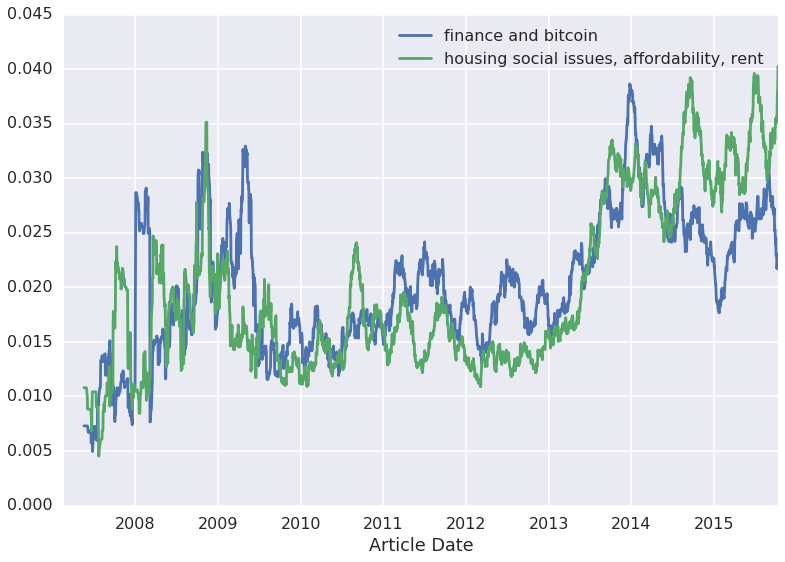

In [528]:
mass = lambda x: ((x) * 1.0).sum() / x.shape[0]
window = 56.0
aggs = {'finance and bitcoin': mass,
        'housing social issues, affordability, rent': mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

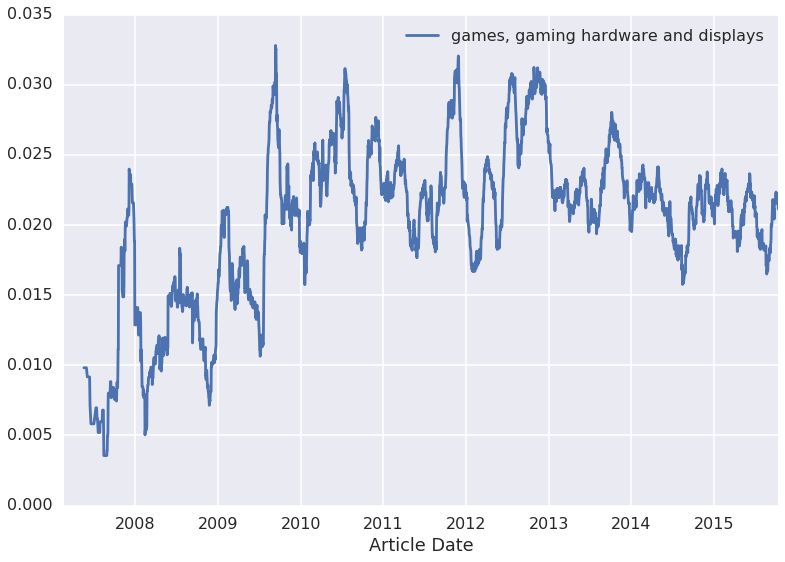

In [529]:
aggs = {'games, gaming hardware and displays': mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

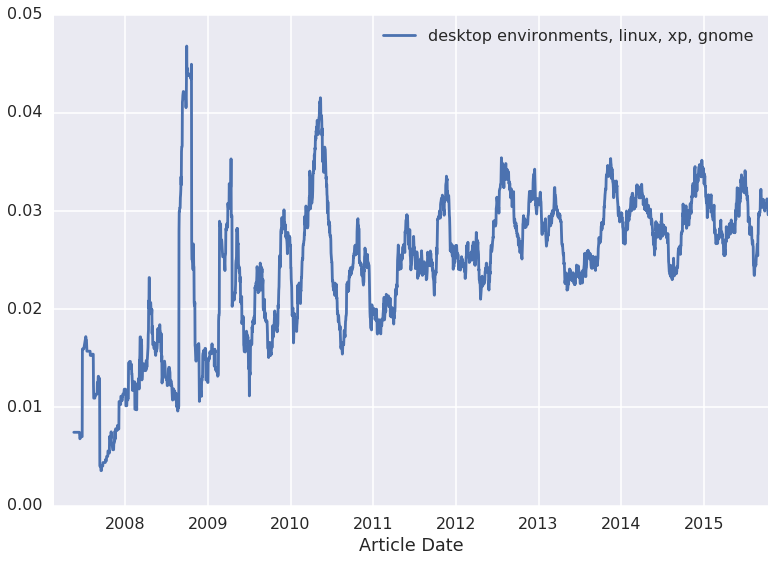

In [530]:
aggs = {'desktop environments, linux, xp, gnome': mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

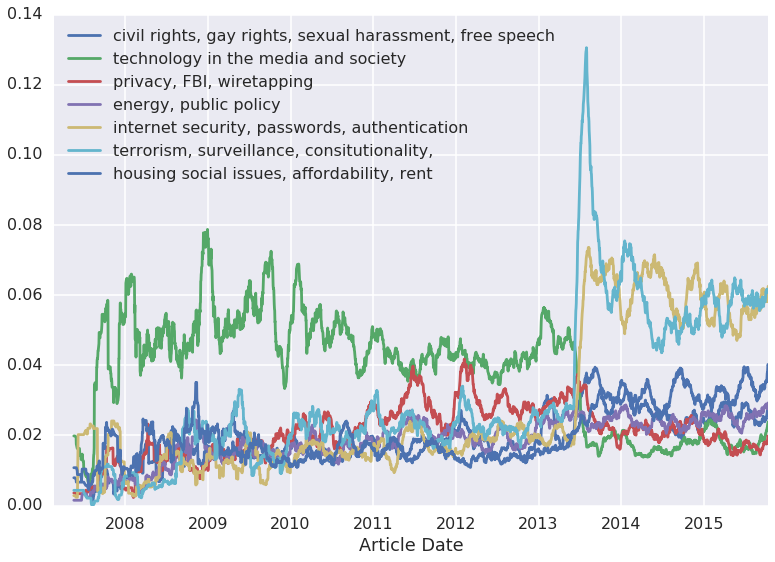

In [531]:
aggs = {
    'housing social issues, affordability, rent': mass,
    'technology in the media and society': mass,
    'civil rights, gay rights, sexual harassment, free speech':mass,
    'internet security, passwords, authentication': mass,
    'privacy, FBI, wiretapping':mass,
    'energy, public policy':mass,
    'terrorism, surveillance, consitutionality, ':mass,
    }
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

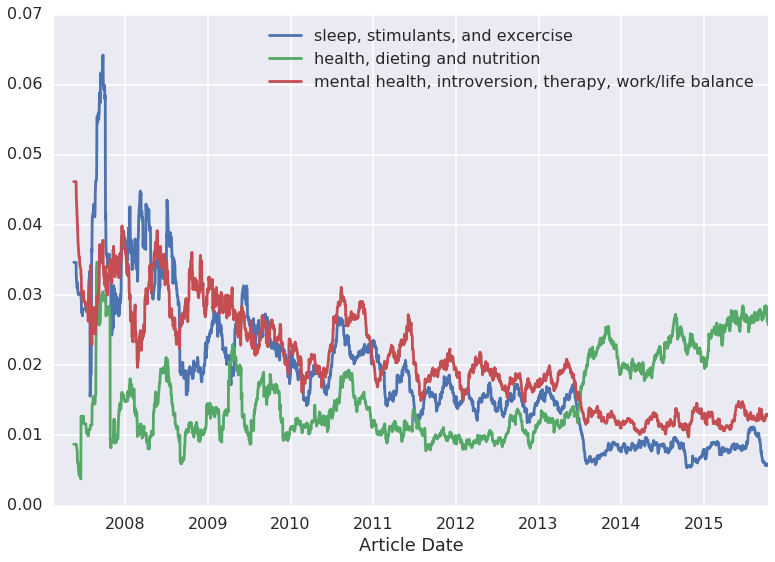

In [532]:
aggs = {
    'health, dieting and nutrition': mass, 
    'sleep, stimulants, and excercise':mass,
    'mental health, introversion, therapy, work/life balance':mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

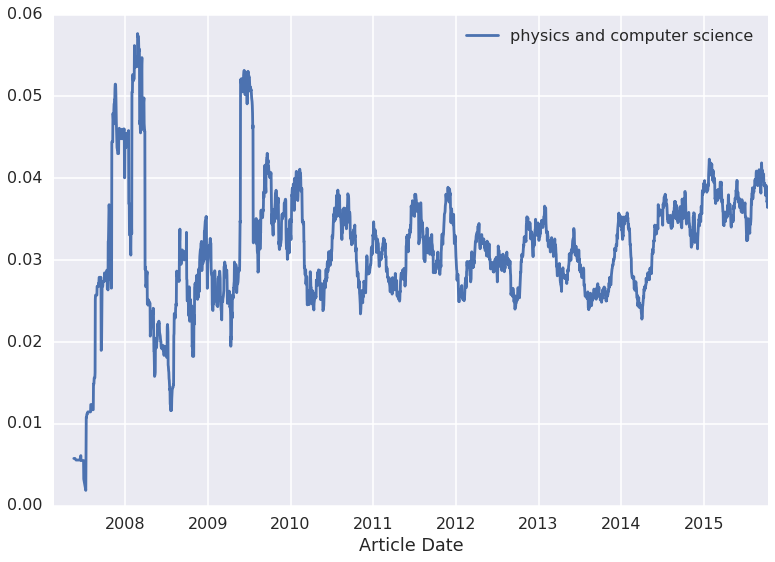

In [533]:
aggs = {
    'physics and computer science': mass,    }
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

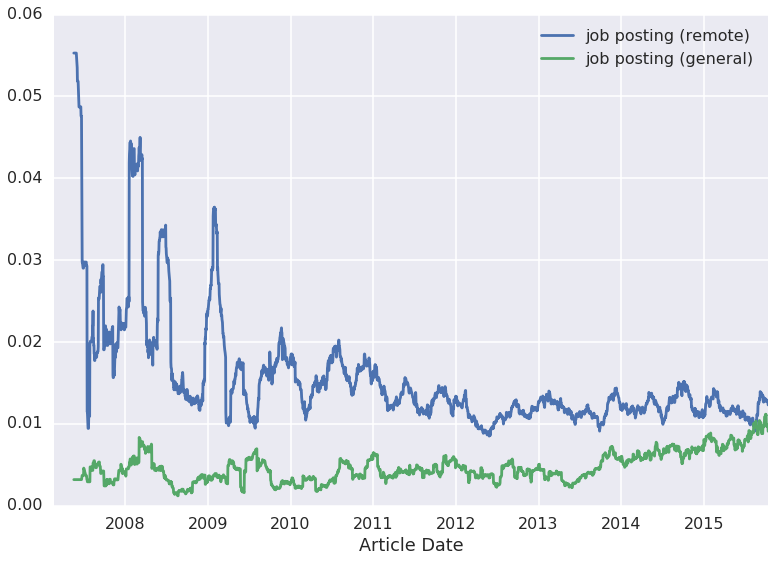

In [534]:
aggs = {'job posting (remote)': mass, 'job posting (general)': mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.date).agg(aggs), window).plot()

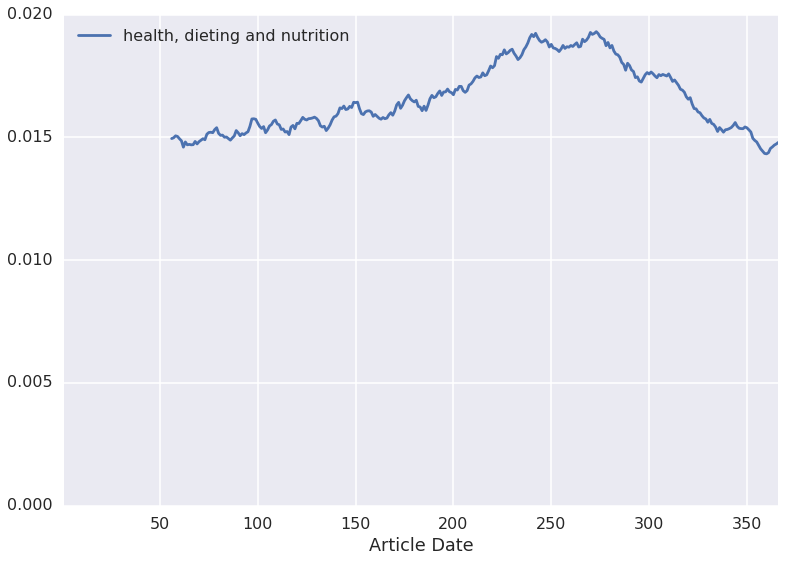

In [536]:
aggs = {'health, dieting and nutrition': mass}
pd.rolling_mean(trends.groupby(trends['Article Date'].dt.dayofyear).agg(aggs), 56.0).plot(ylim=[0, 0.02])

### Visualize Author Topics

Unfortunately, this is a failed experiment! Looking at the user-level topics just generates nonsense. There might be one or two coherent topics in the bunch, but for the most part it makes very little sense.

In [ ]:
prepared_data_author = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                        dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0)

In [7]:
npz = np.load(open('topics.author.pyldavis.npz', 'r'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()
top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print msg
    topic_to_topwords[j] = top_words

Topic 0 out_of_vocabulary submitted article <SKIP> cognate work-sample test href="http://norvig.com/experiment xtopdf learners democratic self-government p.
Topic 1 out_of_vocabulary  <SKIP> wasen&#x27;t  probally twiddla --and huge engagement &quot;rent
Topic 2  out_of_vocabulary <SKIP> alot ie- ve wasen&#x27;t realy nt bad product
Topic 3 portfolio:<p extensive experience building e-com heta resourceful.<p>reach tax experts music artists here&#x27;re href="http://github.com/sidmitra rel="nofollow">http:&#x2f;&#x2f;www rel="nofollow">http:&#x2f;&#x2f;git
Topic 4 rel="nofollow">http:&#x2f;&#x2f;tur accountants.<p courses.<p tax experts intuit]<p rel="nofollow">http:&#x2f;&#x2f;git href="http://github.com/sidmitra rel="nofollow">http:&#x2f;&#x2f;www music artists out_of_vocabulary
Topic 5 submitted article great web software substantial annual turnover july 2007 limited-time online sales current name-brand goods homeware lifestyle categories tricky integration test postdoctoral fellows


In [9]:
pyLDAvis.display(prepared_data_author)